# Final Project Report: Predicting Newsletter Subscription in Minecraft Players
**Broad Question:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? <br>
**Specific Question:** How does age and play time predict the likelihood of an individual subscribing to a game-related newsletter? 

## Introduction

## Methods & Results
1. **Load Data**: Read `players.csv`.<br>
2. **Wrangle/Clean**: Impute missing values.<br>
3. **Summarize**: Compute means and proportions of subscribe.<br>
4. **Visualize**: Plot playtime and age against subscribe.<br>
5. **Analyze**: Use KNN classification to predict `subscribe` with `played_hours` and `Age`.<br>
6. **Visualize Results**: Scatterplot of predictions.<br>

In [55]:
# Load libraries
library(tidymodels)
library(dplyr)
library(ggplot2)

# 1. Load data
players <- read.csv("players.csv")

# 2. Wrangle and clean
players <- players |>
    select(subscribe, played_hours, Age) |>
    mutate(
        subscribe = as.factor(subscribe)  # Convert logical to factor for classification
  )

players_recipe <- recipe(~ ., data = players) |>
  step_impute_mean(Age) |>   # impute missing age
  prep()
players <- bake(players_recipe, new_data = players)

# display data
head(players)
tail(players)

# 3. Summary
summary_table <- players |>
    summarise(
        Mean_Played_Hours_for_all = mean(played_hours),
        Mean_Age_for_all = mean(Age),
        Prop_Subscribed = mean(as.numeric(subscribe) - 1)  
  )

# display the summary
summary_table

subscribe,played_hours,Age
<fct>,<dbl>,<int>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


subscribe,played_hours,Age
<fct>,<dbl>,<int>
TRUE,0.0,20
TRUE,0.0,17
FALSE,0.3,22
FALSE,0.0,17
FALSE,2.3,17
TRUE,0.2,21


Mean_Played_Hours,Mean_Age,Prop_Subscribed
<dbl>,<dbl>,<dbl>
5.845918,20.52551,0.7346939


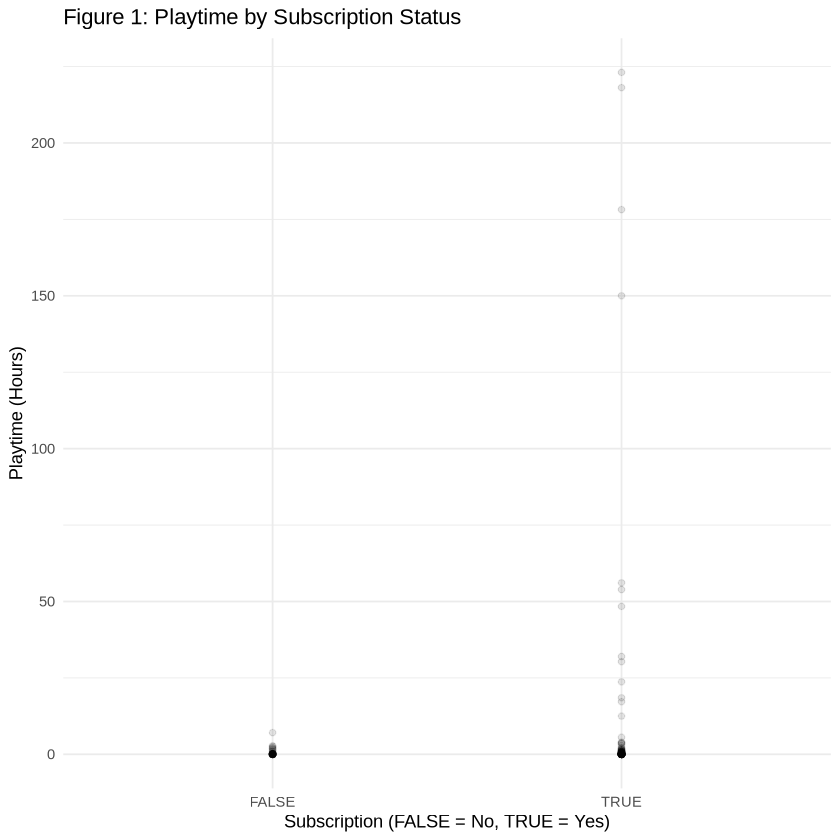

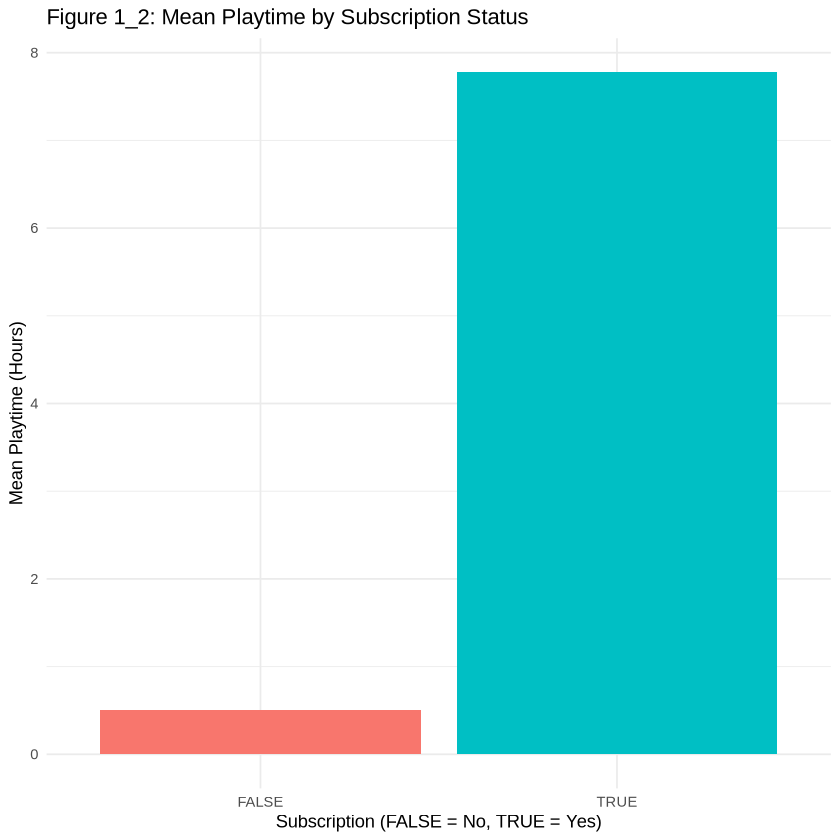

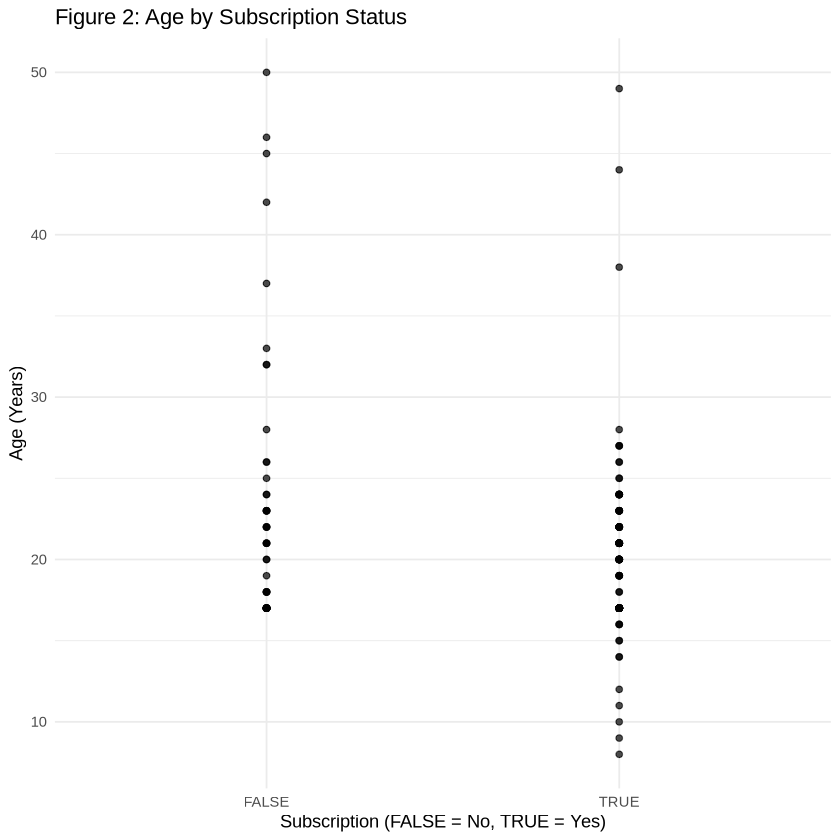

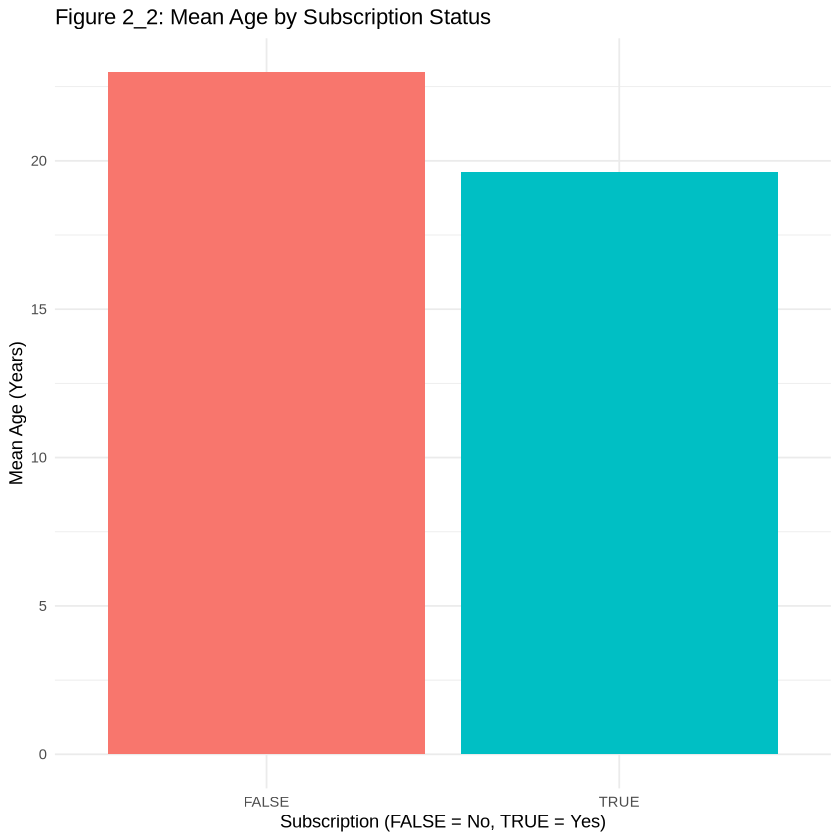

In [53]:
# 4. Visualization 
# Figure 1: Playtime by Subscription
fig1 <- ggplot(players, aes(x = subscribe, y = played_hours)) +
  geom_point(alpha = 0.1) +
  labs(x = "Subscription (FALSE = No, TRUE = Yes)", y = "Playtime (Hours)", 
       title = "Figure 1: Playtime by Subscription Status") +
  theme_minimal()

fig1_2 <- players |>
  group_by(subscribe) |>
  summarise(mean_playtime = mean(played_hours)) |>
  ggplot(aes(x = subscribe, y = mean_playtime, fill = subscribe)) +
  geom_bar(stat = "identity", show.legend = FALSE) +
  labs(x = "Subscription (FALSE = No, TRUE = Yes)", y = "Mean Playtime (Hours)", 
       title = "Figure 1_2: Mean Playtime by Subscription Status") +
  theme_minimal()

# display figure 1
fig1
fig1_2

# Figure 2: Age by Subscription
fig2 <- ggplot(players, aes(x = subscribe, y = Age)) +
  geom_point(alpha = 0.7) +
  labs(x = "Subscription (FALSE = No, TRUE = Yes)", y = "Age (Years)", 
       title = "Figure 2: Age by Subscription Status") +
  theme_minimal()

fig2_2 <- players |>
  group_by(subscribe) |>
  summarise(mean_age = mean(Age)) |>
  ggplot(aes(x = subscribe, y = mean_age, fill = subscribe)) +
  geom_bar(stat = "identity", show.legend = FALSE) +
  labs(x = "Subscription (FALSE = No, TRUE = Yes)", y = "Mean Age (Years)", 
       title = "Figure 2_2: Mean Age by Subscription Status") +
  theme_minimal()

# display figure 2
fig2
fig2_2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.65


[1] "FALSE" "TRUE"

# A tibble: 1 × 3
  .metric   .estimator .estimate
  <chr>     <chr>          <dbl>
1 precision binary         0.391
# A tibble: 1 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 recall  binary         0.562
          Truth
Prediction FALSE TRUE
     FALSE     9   14
     TRUE      7   30


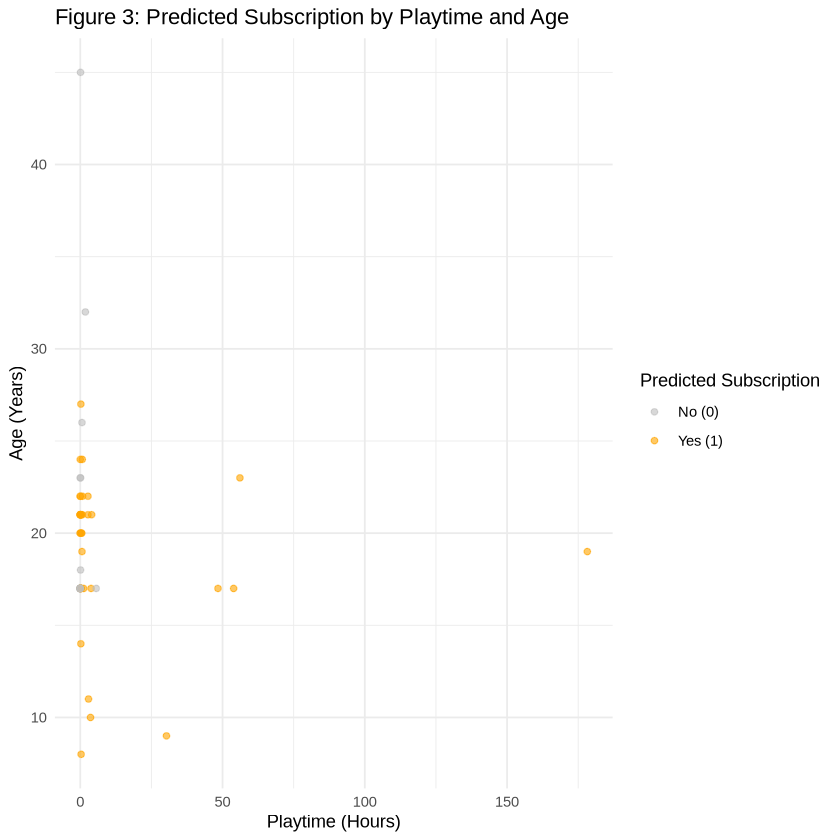

In [56]:
# 5. Data Analysis with KNN
# Split data
set.seed(123)
split <- initial_split(players, prop = 0.7, strata = subscribe)
train_data <- training(split)
test_data <- testing(split)

# Workflow with standardization
recipe <- recipe(subscribe ~ played_hours + Age, data = train_data) |>
  step_scale(all_predictors()) |>  
  step_center(all_predictors()) |>  
  prep()

# Model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
  set_engine("kknn") |>
  set_mode("classification")

# Train model
knn_fit <- knn_spec |>
  fit(subscribe ~ played_hours + Age, data = bake(recipe, train_data))

# Make predictions
test_pred <- predict(knn_fit, new_data = bake(recipe, test_data)) |>
  bind_cols(test_data |> select(subscribe))  

# Accuracy
metrics <- test_pred |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
metrics

# Levels of the response variable
test_pred |> pull(subscribe) |> levels()

# Precision
precision <- test_pred |>
  precision(truth = subscribe, estimate = .pred_class, event_level = "first")
print(precision)

# Recall
recall <- test_pred |>
  recall(truth = subscribe, estimate = .pred_class, event_level = "first")
print(recall)

# Confusion matrix
confusion <- test_pred |>
  conf_mat(truth = subscribe, estimate = .pred_class)
print(confusion)

# 6. Visualization of Analysis
# Figure 3: Predictions Scatterplot
fig3 <- ggplot(test_data, aes(x = played_hours, y = Age, color = test_pred$.pred_class)) +
  geom_point(alpha = 0.6) +
  labs(x = "Playtime (Hours)", y = "Age (Years)", 
       title = "Figure 3: Predicted Subscription by Playtime and Age", 
       color = "Predicted Subscription") +
  scale_color_manual(values = c("gray", "orange"), labels = c("No (0)", "Yes (1)")) +
  theme_minimal()

# display figure 3
fig3

## Discussion

## Reference